In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline


### Reading and splitting data

In [3]:
data = pd.read_csv("aqarmap_data/cleaned_housing_data.csv")
data.head(3)

,URL,Price,Rooms,Baths,Area,Lat,Lon,Floor,Finishing,Governate,Neighbourhood
0,https://aqarmap.com.eg/ar/listing/5923848-for-...,7900000,3,3,176,30.015287,30.983945,4,نصف تشطيب,القاهرة الكبرى,كمبوند تراس
1,https://aqarmap.com.eg/ar/listing/6108263-for-...,13000000,4,4,245,30.100866,31.632139,1,سوبر لوكس,القاهرة الكبرى,طريق مدينتي
2,https://aqarmap.com.eg/ar/listing/6418731-for-...,7500000,3,2,180,30.024799,31.516782,1,سوبر لوكس,القاهرة الكبرى,اللوتس الجديدة


now we create a feature matrix X_train and target vector y_train. target is "price". our features should be all the columns except Neighbourhood and URL.

trying to drop the multicolinear data (rooms, baths)

In [40]:
X_train = data.drop(columns=["Price","URL","Neighbourhood","Baths","Rooms"])
y_train = data["Price"]
X_train.head()

,Area,Lat,Lon,Floor,Finishing,Governate
0,176,30.015287,30.983945,4,نصف تشطيب,القاهرة الكبرى
1,245,30.100866,31.632139,1,سوبر لوكس,القاهرة الكبرى
2,180,30.024799,31.516782,1,سوبر لوكس,القاهرة الكبرى
3,230,30.034311,31.461851,1,اكسترا سوبر لوكس,القاهرة الكبرى
4,116,29.986745,31.319028,1,سوبر لوكس,القاهرة الكبرى


### Building the model

In [35]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean]*len(y_train)
print("Mean apt price:", y_mean.round(2))

print("Baseline MAE:", mean_absolute_error(y_train,y_pred_baseline))

Mean apt price: 6447173.62
Baseline MAE: 2839399.4152118056


Create a pipeline named model that contains a OneHotEncoder and Linear regression predictor

In [41]:
numeric = [ "Area", "Lat", "Lon", "Floor"]
categorical = ["Finishing", "Governate"]

In [60]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric),  # Use raw values
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical)
    ]
)


In [61]:
model = make_pipeline(
    preprocessor,
    Ridge()
)
model.fit(X_train,y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('columntransformer', ...), ('ridge', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

In [62]:
y_pred_training = model.predict(X_train)
print("Training MAE:", mean_absolute_error(y_train,y_pred_training))

Training MAE: 2164477.3578676316


### Communicate Results

In [63]:
intercept = model.named_steps["ridge"].intercept_
coefficients = model.named_steps["ridge"].coef_
print("coefficients len:", len(coefficients))
print(coefficients[:5])  # First five coefficients

coefficients len: 26
[  26076.66974328 1398914.71792085 1180327.07064267 -158370.81891873
 1203288.24027035]


In [64]:

feature_names = model.named_steps["columntransformer"].get_feature_names_out(X_train.columns)
print("features len:", len(feature_names))
print(feature_names[:50])  # First five feature names

features len: 26
['num__Area' 'num__Lat' 'num__Lon' 'num__Floor'
 'cat__Finishing_اكسترا سوبر لوكس' 'cat__Finishing_بدون تشطيب'
 'cat__Finishing_سوبر لوكس' 'cat__Finishing_لوكس'
 'cat__Finishing_نصف تشطيب' 'cat__Governate_الاسكندرية'
 'cat__Governate_الاسماعيلية' 'cat__Governate_البحر الأحمر'
 'cat__Governate_التوسعات السياحية الشمالية' 'cat__Governate_الجيزة'
 'cat__Governate_الدقهلية' 'cat__Governate_الساحل الشمالي'
 'cat__Governate_السويس' 'cat__Governate_الشرقية'
 'cat__Governate_العين السخنة' 'cat__Governate_القاهرة الكبرى'
 'cat__Governate_القليوبية' 'cat__Governate_المنوفية'
 'cat__Governate_المنيا' 'cat__Governate_بور سعيد' 'cat__Governate_دمياط'
 'cat__Governate_مرسى مطروح']


In [65]:
feat_imp = pd.Series(coefficients,index=feature_names)
feat_imp.head()

num__Area                          2.607667e+04
num__Lat                           1.398915e+06
num__Lon                           1.180327e+06
num__Floor                        -1.583708e+05
cat__Finishing_اكسترا سوبر لوكس    1.203288e+06
dtype: float64

In [66]:
print(f"price = {intercept.round(2)}")
for f, c in feat_imp.items():
    print(f"+ ({round(c, 2)} * {f})")

price = -77018174.61
+ (26076.67 * num__Area)
+ (1398914.72 * num__Lat)
+ (1180327.07 * num__Lon)
+ (-158370.82 * num__Floor)
+ (1203288.24 * cat__Finishing_اكسترا سوبر لوكس)
+ (-194745.88 * cat__Finishing_بدون تشطيب)
+ (-341015.32 * cat__Finishing_سوبر لوكس)
+ (13664.27 * cat__Finishing_لوكس)
+ (-681191.31 * cat__Finishing_نصف تشطيب)
+ (2420449.89 * cat__Governate_الاسكندرية)
+ (-644334.83 * cat__Governate_الاسماعيلية)
+ (1645346.22 * cat__Governate_البحر الأحمر)
+ (-188114.78 * cat__Governate_التوسعات السياحية الشمالية)
+ (-207711.33 * cat__Governate_الجيزة)
+ (-1512603.66 * cat__Governate_الدقهلية)
+ (4465656.29 * cat__Governate_الساحل الشمالي)
+ (-3295063.88 * cat__Governate_السويس)
+ (-198142.7 * cat__Governate_الشرقية)
+ (215637.88 * cat__Governate_العين السخنة)
+ (1299136.7 * cat__Governate_القاهرة الكبرى)
+ (-299503.11 * cat__Governate_القليوبية)
+ (-341822.68 * cat__Governate_المنوفية)
+ (-52890.16 * cat__Governate_المنيا)
+ (-367516.71 * cat__Governate_بور سعيد)
+ (-2607859.1

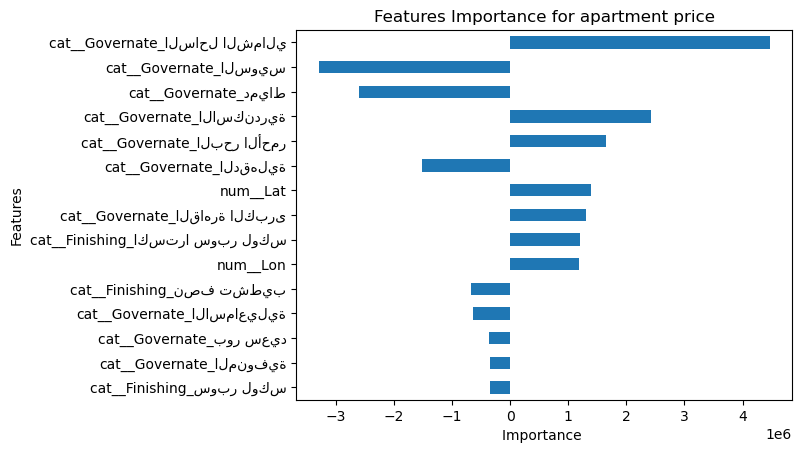

In [67]:
feat_imp.sort_values(key=abs).tail(15).plot(kind="barh")
plt.xlabel("Importance ")
plt.ylabel("Features")
plt.title("Features Importance for apartment price");

In [68]:

def make_prediction(Rooms,Baths,Area,Lat,Lon,Floor,Finishing,Governate):
    data = {"Rooms":Rooms,
            "Baths" :Baths,
            "Area":Area,
            "Lat":Lat,
            "Lon":Lon,
            "Floor":Floor,
            "Finishing":Finishing,
            "Governate":Governate
           }
    df = pd.DataFrame(data, index=[0])
    print(df)
    prediction = model.predict(df).round(2)[0]
    return f"Predicted apartment price: ${prediction}"
make_prediction(2,2,120,30.0444,31.2357,3,"لوكس","القاهره الكبري")

   Rooms  Baths  Area      Lat      Lon  Floor Finishing       Governate
0      2      2   120  30.0444  31.2357      3      لوكس  القاهره الكبري


'Predicted apartment price: $4547473.2'

In [69]:
interact(
    make_prediction, 
    
        # Match the argument name 'Area' from the function
    Area=IntSlider(
        min=int(X_train["Area"].min()), 
        max=int(X_train["Area"].max()), 
        value=int(X_train["Area"].mean()),
    ),
    Lat=FloatSlider(
        min=X_train["Lat"].min(), 
        max=X_train["Lat"].max(), 
        step=0.01, 
        value=X_train["Lat"].mean(),
    ),
    Lon=FloatSlider(
        min=X_train["Lon"].min(), 
        max=X_train["Lon"].max(), 
        step=0.01, 
        value=X_train["Lon"].mean(),
    ),
    # Added missing sliders for Rooms, Baths, Floor, and Finishing
    Rooms=IntSlider(min=1, max=10, step=1, value=3),
    Baths=IntSlider(min=1, max=5, step=1, value=2),
    Floor=IntSlider(min=0, max=20, step=1, value=1),
    Finishing=Dropdown(options=sorted(X_train["Finishing"].unique())),
    
    # Match 'Governate' with your function argument
    Governate=Dropdown(options=sorted(X_train["Governate"].unique()))
);

interactive(children=(IntSlider(value=3, description='Rooms', max=10, min=1), IntSlider(value=2, description='…

## saving the model

In [70]:
import joblib

# saves trained pipeline
joblib.dump(model, 'house_model.pkl')

print("Model saved successfully as house_model.pkl")

Model saved successfully as house_model.pkl


In [74]:
data[data["Governate"] == "البحر الأحمر"]

,URL,Price,Rooms,Baths,Area,Lat,Lon,Floor,Finishing,Governate,Neighbourhood
5,https://aqarmap.com.eg/ar/listing/6449358-for-...,11214000,1,1,178,27.248246,33.829404,1,سوبر لوكس,البحر الأحمر,الاحياء
10,https://aqarmap.com.eg/ar/listing/6429293-for-...,3070200,1,1,68,27.218941,33.834897,1,سوبر لوكس,البحر الأحمر,شارع الشيراتون
11,https://aqarmap.com.eg/ar/listing/6522436-for-...,7335253,1,1,106,27.248246,33.829404,2,سوبر لوكس,البحر الأحمر,الاحياء
15,https://aqarmap.com.eg/ar/listing/6454355-for-...,3900000,2,1,75,27.248246,33.829404,1,سوبر لوكس,البحر الأحمر,الاحياء
24,https://aqarmap.com.eg/ar/listing/6111842-for-...,4050000,2,1,135,27.218941,33.834897,3,سوبر لوكس,البحر الأحمر,شارع الشيراتون
...,...,...,...,...,...,...,...,...,...,...,...
7427,https://aqarmap.com.eg/ar/listing/6129875-for-...,3195000,1,1,77,27.249746,33.826904,1,سوبر لوكس,البحر الأحمر,منتجع لافاندا بيتش
7457,https://aqarmap.com.eg/ar/listing/6377373-for-...,2650000,1,1,50,27.200900,33.837891,1,سوبر لوكس,البحر الأحمر,كورنيش الغردقة
7484,https://aqarmap.com.eg/ar/listing/6440511-for-...,2293980,1,1,40,27.230210,33.832397,1,سوبر لوكس,البحر الأحمر,حي الكوثر
7487,https://aqarmap.com.eg/ar/listing/6331247-for-...,2610000,1,1,58,27.142257,33.810425,2,سوبر لوكس,البحر الأحمر,منتجع مجاويش
